# Download Dataset

In [1]:
from IPython.core.pylabtools import figsize
!gdown --id 1sQEIPh3bdKQ_1J3g0Z8CRqD6uU7v746l

^C


In [2]:
!unzip dataset.zip

^C


In [1]:
import pathlib
data_dir = pathlib.Path("./flowers")
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

4317


# Load dataset

In [2]:
from PIL import Image
import numpy as np
import os

dataset = []
count = 0
for label in os.listdir("./flowers/"):
    for filename in os.listdir(os.path.join("./flowers/",label)):
        count = count + 1
        print(str(count) + " ---loading " + filename)
        image = Image.open(os.path.join("./flowers/",label,filename))
        image.load()
        image = np.asarray(image, dtype="float32" )
        dataset.append((image, label))

1 ---loading 100080576_f52e8ee070_n.jpg
2 ---loading 10140303196_b88d3d6cec.jpg
3 ---loading 10172379554_b296050f82_n.jpg
4 ---loading 10172567486_2748826a8b.jpg
5 ---loading 10172636503_21bededa75_n.jpg
6 ---loading 102841525_bd6628ae3c.jpg
7 ---loading 10300722094_28fa978807_n.jpg
8 ---loading 1031799732_e7f4008c03.jpg
9 ---loading 10391248763_1d16681106_n.jpg
10 ---loading 10437754174_22ec990b77_m.jpg
11 ---loading 10437770546_8bb6f7bdd3_m.jpg
12 ---loading 10437929963_bc13eebe0c.jpg
13 ---loading 10466290366_cc72e33532.jpg
14 ---loading 10466558316_a7198b87e2.jpg
15 ---loading 10555749515_13a12a026e.jpg
16 ---loading 10555815624_dc211569b0.jpg
17 ---loading 10555826524_423eb8bf71_n.jpg
18 ---loading 10559679065_50d2b16f6d.jpg
19 ---loading 105806915_a9c13e2106_n.jpg
20 ---loading 10712722853_5632165b04.jpg
21 ---loading 107592979_aaa9cdfe78_m.jpg
22 ---loading 10770585085_4742b9dac3_n.jpg
23 ---loading 10841136265_af473efc60.jpg
24 ---loading 10993710036_2033222c91.jpg
25 ---loadin

In [3]:
import random
print(random.sample(dataset, 10))

[(array([[[103., 113.,  86.],
        [112., 121.,  92.],
        [104., 112.,  75.],
        ...,
        [  1.,   1.,   1.],
        [  1.,   1.,   1.],
        [  1.,   1.,   1.]],

       [[ 99., 108.,  79.],
        [ 99., 108.,  77.],
        [ 85.,  93.,  54.],
        ...,
        [  1.,   1.,   1.],
        [  1.,   1.,   1.],
        [  1.,   1.,   1.]],

       [[104., 113.,  82.],
        [ 98., 105.,  71.],
        [ 77.,  86.,  43.],
        ...,
        [  1.,   1.,   1.],
        [  1.,   1.,   1.],
        [  1.,   1.,   1.]],

       ...,

       [[ 26.,  48.,  12.],
        [ 30.,  44.,  31.],
        [ 15.,  20.,  23.],
        ...,
        [ 10.,  17.,   9.],
        [  7.,  14.,   6.],
        [ 11.,  16.,  10.]],

       [[ 27.,  46.,  14.],
        [ 24.,  38.,  25.],
        [ 14.,  19.,  22.],
        ...,
        [ 10.,  22.,  10.],
        [  8.,  15.,   7.],
        [ 13.,  15.,  10.]],

       [[ 25.,  44.,  12.],
        [ 21.,  33.,  23.],
        [ 13.,

In [4]:
import random
random.shuffle(dataset)

# Display dataset

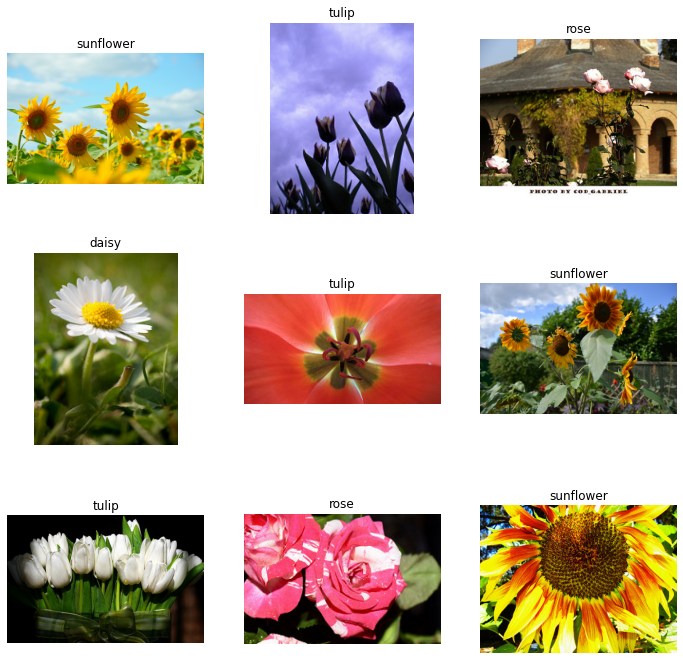

In [5]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(3, 3, figsize = (12, 12))
plt.gray()

for i, ax in enumerate(axs.flat):
    ax.imshow(dataset[i][0].astype("int32"))
    ax.axis('off')
    ax.set_title(dataset[i][1])
plt.show()

# Preprocessing

## Resizing

In [6]:
image_size = (32, 32)

In [7]:
import cv2
resized = []
for d in dataset:
    resized.append((cv2.resize(d[0], image_size), d[1]))

In [8]:
dataset = resized

## Reshape

In [9]:
images = np.asarray([d[0] for d in dataset])
print(images.shape)

(4317, 32, 32, 3)


In [10]:
images = images.reshape(len(images), -1)
print(images.shape)

(4317, 3072)


## Normalization

In [11]:
images = images.astype(np.float32) / 255.

# K-Means Clustering

In [12]:
from sklearn.cluster import MiniBatchKMeans
number_clusters = 5
kmeans = MiniBatchKMeans(n_clusters=number_clusters)
kmeans.fit(images)

MiniBatchKMeans(n_clusters=5)

## Map clusters to classes

On ajoute à nos clusters les étiquettes en se basant sur le nombre d'occurrence maximum, dans le cas d'un cluster vide, on lui attribue 0

In [24]:
def map_clusters_classes(kmeans, classes, clusters):
    mapping = {}

    for i in range(kmeans.n_clusters):
        res = list()
        row = np.where(i == clusters)[0]

        if 0 == len(row):
            mapping[i] = 0
            continue

        for j in range(len(row)):
            res.append(classes[row[j]])

        mapping[i] = np.bincount(res).argmax()
    return mapping

def inference(kmeans, images, classes):
    clusters = kmeans.predict(images)
    mapping = map_clusters_classes(kmeans, classes, clusters)
    predicted_classes = np.zeros(len(clusters)).astype(np.uint8)
    for i in range(len(clusters)):
        predicted_classes[i] = mapping[clusters[i]]
    return predicted_classes

In [25]:
labels_classes_mapping = {"daisy": 0, "dandelion": 1, "rose": 2, "sunflower": 3, "tulip": 4}
classes = [labels_classes_mapping[d[1]] for d in dataset]
classes = np.asarray(classes)
predicted_classes = inference(kmeans, images, classes)
print(predicted_classes[:20])
print(classes[:20])

[1 1 4 0 3 4 0 0 3 1 3 0 0 4 4 0 0 3 1 0]
[3 4 2 0 4 3 4 2 3 0 4 1 1 4 3 1 4 3 4 4]


# Evaluation

In [26]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(classes, predicted_classes)
print('Accuracy: {}\n'.format(acc))

Accuracy: 0.30252490155200373



On va faire des modèles avec un nombre plus élevé de cluster et voir l'évolution de notre précision

In [27]:
number_clusters = [5, 10, 16, 36, 64, 144, 256, 1024, 2048, 4098]
acc_list = []

for n_clusters in number_clusters:
    model = MiniBatchKMeans(n_clusters=n_clusters)
    model.fit(images)
    predicted_classes = inference(model, images, classes)
    acc = accuracy_score(classes, predicted_classes)
    acc_list.append(acc)
    print('Accuracy: {}\n'.format(acc))

Accuracy: 0.2849200833912439

Accuracy: 0.3110956682881631

Accuracy: 0.33356497567755383

Accuracy: 0.3497799397729905

Accuracy: 0.3574241371322678

Accuracy: 0.3933287004864489

Accuracy: 0.4236738475793375

Accuracy: 0.5531619179986101

Accuracy: 0.7062775075283761

Accuracy: 0.9682649988417883



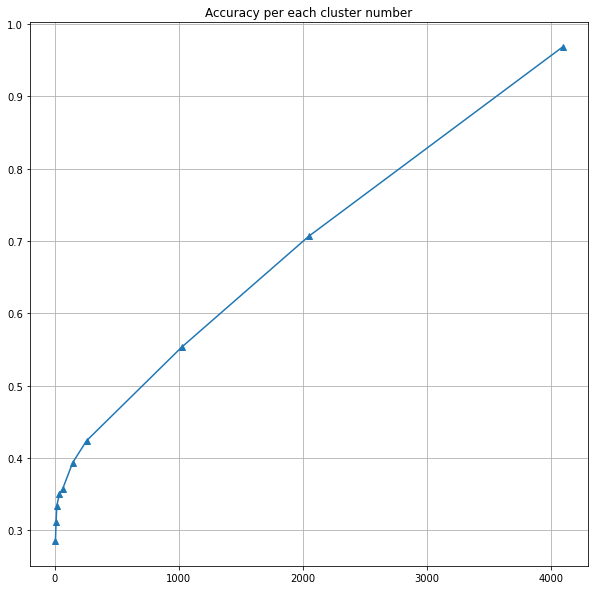

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.plot(number_clusters, acc_list, label="accuracy", marker="^")
ax.grid("on")
ax.set_title("Accuracy per each cluster number")
plt.show()

On peut voir que notre précision s'améliore lorsqu'on augmente le nombre de cluster de notre modèle